<a href="https://colab.research.google.com/github/CristianRiquelmeF/riesgo_crediticio_ml_modelos/blob/main/riesgo_crediticio_ml_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**"Modelo Predictivo de Riesgo Crediticio con Técnicas Avanzadas de Machine Learning"**


> **Objetivo**
Utilizando un dataset de historial crediticio, este proyecto busca predecir el riesgo crediticio de clientes (clasificación binaria: alto riesgo vs. bajo riesgo).

**Metodología**

**1.Modelos de Ensamble:**
  
  - Implementación de técnicas que combinan múltiples modelos débiles (principalmente árboles de decisión) para mejorar la **precisión** y **robustez**.

  - Algoritmos incluidos:

    - Random Forest (bagging) con optimización Grid, Search y Bayesiana.

    - XGBoost y AdaBoost (boosting).

**2.Regularización:**

   - Aplicación de métodos como Lasso (L1) y Ridge (L2) para evaluar su impacto en la generalización del modelo.

**3.Evaluación y Comparación:**

   - Análisis de métricas clave: *Accuracy, Precision, Recall, F1-Score* y AUC-ROC.

   - Interpretación de la importancia de características para identificar predictores críticos.

   - Selección del mejor modelo basado en rendimiento y capacidad explicativa.

**Resultados Esperados**

   - Identificación del algoritmo óptimo para predecir riesgo crediticio.

   - Explicación clara de los factores que influyen en la clasificación.

   - Documentación técnica que justifique la elección del modelo final.

In [97]:
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [ ]:
pip install scikit-optimize

In [40]:
from skopt import BayesSearchCV

## **Carga dataset y revisión preliminar**

In [2]:
# Cargar el dataset "credit"
df = fetch_openml("credit", version=1)
X = df.data
y = df.target

In [3]:
# Convertir a DataFrame para exploración
df = pd.DataFrame(X, columns=df.feature_names)
df['riesgo'] = y

# Ver las primeras filas
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0.0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0.0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0.0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0.0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
print("Cantidad de filas:")
display(df.shape[0])
print("")
print("Número de columnas:")
display(df.shape[1])

Cantidad de filas:


16714


Número de columnas:


11

In [5]:
# Revisión del contenido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  16714 non-null  float64
 1   age                                   16714 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  16714 non-null  float64
 3   DebtRatio                             16714 non-null  float64
 4   MonthlyIncome                         16714 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       16714 non-null  float64
 6   NumberOfTimes90DaysLate               16714 non-null  float64
 7   NumberRealEstateLoansOrLines          16714 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  16714 non-null  float64
 9   NumberOfDependents                    16714 non-null  float64
 10  riesgo                                16714 non-null  float64
dtypes: float64(11)


| Nº | Columna                                | Tipo      | Descripción (estimada por nombre)                     |
| -- | -------------------------------------- | --------- | ----------------------------------------------------- |
| 0  | `RevolvingUtilizationOfUnsecuredLines` | `float64` | Proporción de crédito usado vs. disponible (0–1)      |
| 1  | `age`                                  | `float64` | Edad del solicitante                                  |
| 2  | `NumberOfTime30-59DaysPastDueNotWorse` | `float64` | Número de veces con mora de 30-59 días                |
| 3  | `DebtRatio`                            | `float64` | Proporción deuda / ingresos                           |
| 4  | `MonthlyIncome`                        | `float64` | Ingreso mensual (puede tener outliers)                |
| 5  | `NumberOfOpenCreditLinesAndLoans`      | `float64` | Cantidad de créditos/líneas activas                   |
| 6  | `NumberOfTimes90DaysLate`              | `float64` | Número de veces con mora de 90+ días                  |
| 7  | `NumberRealEstateLoansOrLines`         | `float64` | Cantidad de hipotecas u otros préstamos inmobiliarios |
| 8  | `NumberOfTime60-89DaysPastDueNotWorse` | `float64` | Número de veces con mora de 60-89 días                |
| 9  | `NumberOfDependents`                   | `float64` | Número de dependientes económicos                     |
| 10 | `riesgo`                             | `float64` | **Variable objetivo**: 1 si , 0  no     |


- En este dataset la variable objetivo 'riesgo', representa riesgo crediticio del cliente: 1 = Sí, 0 = No

In [6]:
# Conteo de clases en variable objetivo
df['riesgo'].value_counts()

,count
riesgo,
0.0,8357
1.0,8357


**Variables clave:**

- Comportamiento de pagos (NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate)

- Situación financiera (DebtRatio, MonthlyIncome)

- Historial crediticio (NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines)

In [7]:
df.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
count,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000,16714.000000
mean,4.799862,48.798672,1.110267,30.980298,6118.120258,8.503709,0.863827,1.047445,0.734354,0.944358,0.500000
std,204.062345,13.906078,7.172890,719.694859,5931.841779,5.370965,7.167576,1.272565,7.138737,1.198791,0.500015
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082397,38.000000,0.000000,0.155971,3128.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.443080,48.000000,0.000000,0.322299,5000.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.500000
75%,0.926637,58.000000,1.000000,0.533426,7573.000000,11.000000,0.000000,2.000000,0.000000,2.000000,1.000000
max,22000.000000,101.000000,98.000000,61106.500000,250000.000000,57.000000,98.000000,29.000000,98.000000,8.000000,1.000000


In [8]:
# Observación de valores nulos
df.isnull().sum()

,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0
NumberOfDependents,0


In [9]:
# Revisión valores duplicados
df.duplicated().sum()

np.int64(2)

In [10]:
# Revisión de filas duplicadas
duplicated_rows = df[df.duplicated(keep=False)]  # `keep=False` marca TODOS los duplicados (incluyendo el primero)
duplicated_rows.sort_values(by=list(df.columns))  # Ordena para verlos agrupados

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,riesgo
10133,1.0,22.0,98.0,0.0,0.0,0.0,98.0,0.0,98.0,0.0,1.0
11054,1.0,22.0,98.0,0.0,0.0,0.0,98.0,0.0,98.0,0.0,1.0
11673,1.0,55.0,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,1.0
12257,1.0,55.0,0.0,0.0,1000.0,0.0,1.0,0.0,0.0,0.0,1.0


/tmp/ipython-input-1291960022.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, color='teal', rug=True)


Text(0.5, 0, 'Edad')

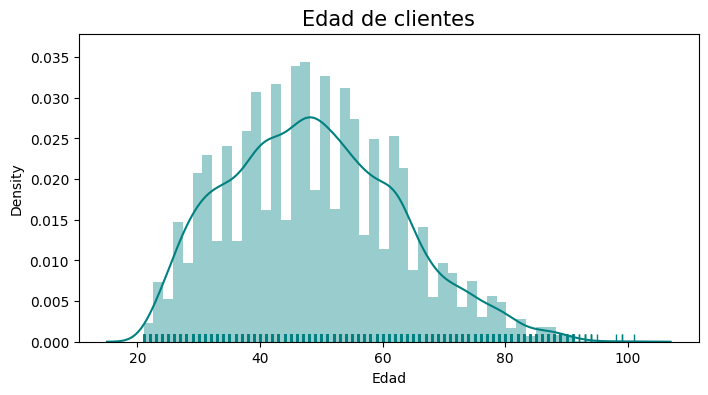

In [11]:
# Gráfica de la distribución edades
plt.figure(figsize=(8,4))
x = df['age']
plt.title('Edad de clientes', fontsize=15)
ax = sns.distplot(x, color='teal', rug=True)
plt.xlabel('Edad')

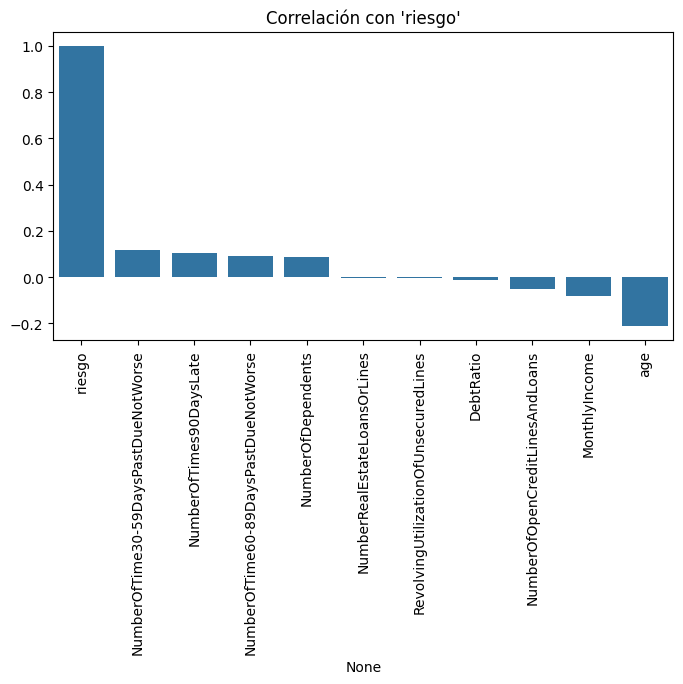

In [12]:
# Correlación con el target
corr_with_target = df.corr()['riesgo'].sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.title("Correlación con 'riesgo'")
plt.show()

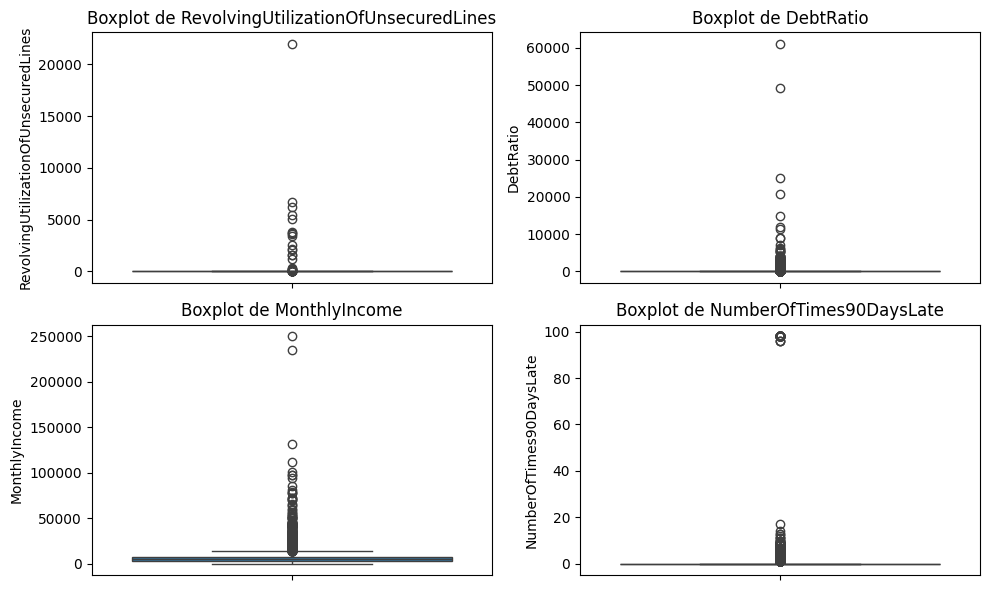

In [13]:
# Outliers en variables clave
outlier_vars = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate'
]

plt.figure(figsize=(10, 6))
for i, col in enumerate(outlier_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

## **Preprocesamiento**

In [14]:
# Convertir de float a entero para evitar problemas en modelos de clasificación en ML.
y = y.astype(int)

In [15]:
# Copia de X para aplicar tratamiento de outliers
X_pre = X.copy()

In [16]:
# Tratamiento de outliers antes de escalar, afectan desempeño en regresión logística.
cols_to_clip = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'NumberOfTimes90DaysLate']
X_pre[cols_to_clip] = X_pre[cols_to_clip].apply(lambda x: x.clip(upper=x.quantile(0.99)))

In [17]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Escalar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Entrenamiento de modelos**

In [19]:
# Función de evaluación
def evaluar_modelo(nombre, modelo):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    print(f"\n--- {nombre} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

**Random Forest**


--- Random Forest ---
Accuracy: 0.7759497457373616
Precision: 0.7744047619047619
Recall: 0.7785757031717534
F1-Score: 0.7764846314532975
AUC-ROC: 0.8521247269062161

               precision    recall  f1-score   support

           0       0.78      0.77      0.78      1672
           1       0.77      0.78      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



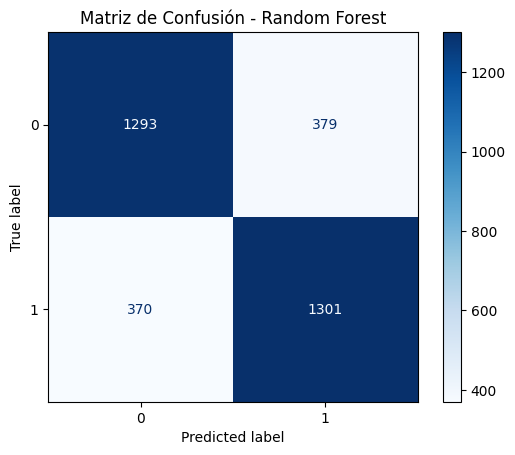

In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluar_modelo("Random Forest", rf)

**Random Forest con Grid Search**

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores hiperparámetros (Grid Search): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 120}

--- Random Forest con Grid Search ---
Accuracy: 0.7813341310200419
Precision: 0.7841596130592503
Recall: 0.7761819269898265
F1-Score: 0.7801503759398496
AUC-ROC: 0.8618778973711413

               precision    recall  f1-score   support

           0       0.78      0.79      0.78      1672
           1       0.78      0.78      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



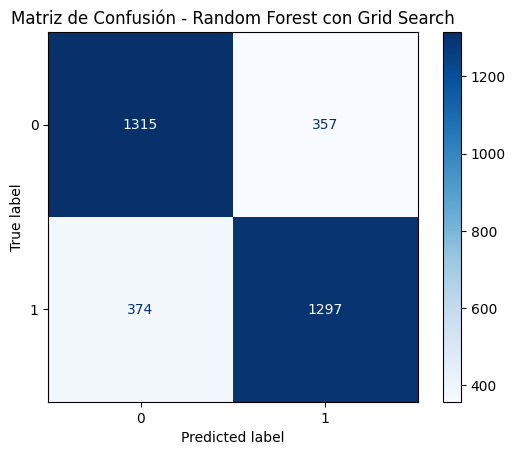

In [105]:
# Definir los parámetros para Grid Search
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Configurar Grid Search
grid_search = GridSearchCV(estimator=rf,
                          param_grid=param_grid,
                          cv=3,
                          n_jobs=-1,
                          verbose=2,
                          scoring='accuracy')
# Ejecutar Grid Search
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros (Grid Search):", grid_search.best_params_)
best_grid = grid_search.best_estimator_

evaluar_modelo("Random Forest con Grid Search", best_grid)

**Random Forest con Random Search**

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores parámetros (Random Search): {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 61}

--- Random Forest con Random Search ---
Accuracy: 0.7816332635357464
Precision: 0.783946891973446
Recall: 0.77737881508079
F1-Score: 0.7806490384615384
AUC-ROC: 0.8615296401604633

               precision    recall  f1-score   support

           0       0.78      0.79      0.78      1672
           1       0.78      0.78      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



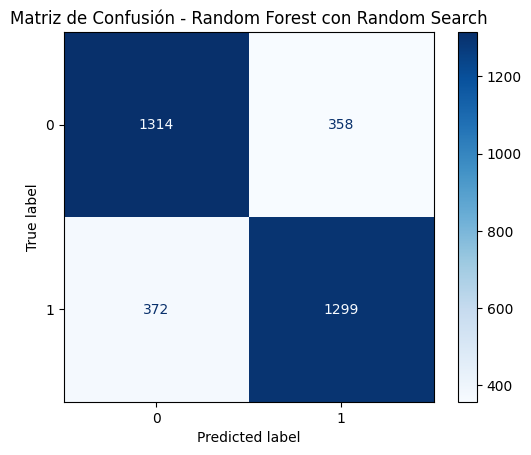

In [101]:
# Definir la distribución de parámetros para Random Search
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
}

# Configurar Random Search
random_search = RandomizedSearchCV(estimator=rf,
                                 param_distributions=param_dist,
                                 n_iter=30,  # Número de combinaciones a probar
                                 cv=3,
                                 n_jobs=-1,
                                 verbose=2,
                                 random_state=42,
                                 scoring='accuracy')

# Ejecutar Random Search
random_search.fit(X_train, y_train)
print("Mejores parámetros (Random Search):", random_search.best_params_)
best_random = random_search.best_estimator_

evaluar_modelo("Random Forest con Random Search", best_random)

**Random Forest con Optimización Bayesiana - Scikit Optimize**


--- Random Forest con Optimización Bayesiana ---
Accuracy: 0.7792402034101107
Precision: 0.7811934900542495
Recall: 0.7755834829443446
F1-Score: 0.7783783783783784
AUC-ROC: 0.8610378565967718

               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1672
           1       0.78      0.78      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



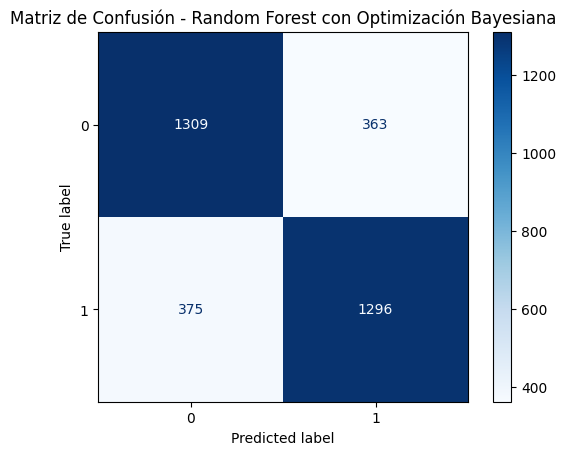

In [102]:
# Definición de espacio de búsqueda
searh_space = {'n_estimators': (50, 200),
               'max_depth': (3, 20),
               'min_samples_split': (2, 10)}

# Configurar el modelo
opt= BayesSearchCV(estimator= rf,
                   search_spaces=searh_space,
                   n_iter=30,
                   cv=3,
                   scoring='f1',
                   n_jobs=-1,
                   random_state=42)

opt.fit(X_train, y_train)
evaluar_modelo("Random Forest con Optimización Bayesiana", opt)

**XGBoost**


--- XGBoost ---
Accuracy: 0.780735865988633
Precision: 0.7923940149625935
Recall: 0.760622381807301
F1-Score: 0.7761832061068702
AUC-ROC: 0.8600324562835194

               precision    recall  f1-score   support

           0       0.77      0.80      0.79      1672
           1       0.79      0.76      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



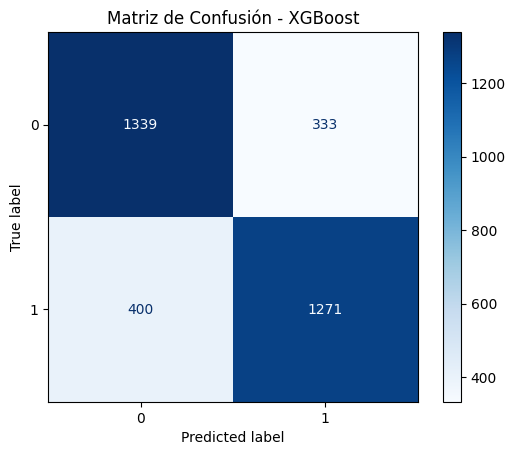

In [42]:
#Crear y entrenar modelo XGBoost
xg = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss')

xg.fit(X_train, y_train)
evaluar_modelo("XGBoost", xg)

**AdaBoost**


--- AdaBoost ---
Accuracy: 0.7690696978761591
Precision: 0.7843137254901961
Recall: 0.7420706163973668
F1-Score: 0.7626076260762608
AUC-ROC: 0.8496452286256689

               precision    recall  f1-score   support

           0       0.76      0.80      0.78      1672
           1       0.78      0.74      0.76      1671

    accuracy                           0.77      3343
   macro avg       0.77      0.77      0.77      3343
weighted avg       0.77      0.77      0.77      3343



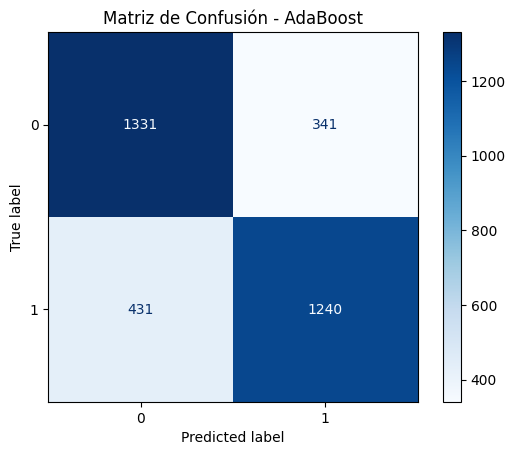

In [45]:
# Crear y entrenar modelo AdaBoost
ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42)

ada.fit(X_train, y_train)
evaluar_modelo("AdaBoost", ada)

**Regresión logística sin regularización**


--- Logistic Regression (sin regularización) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8423407752284252

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



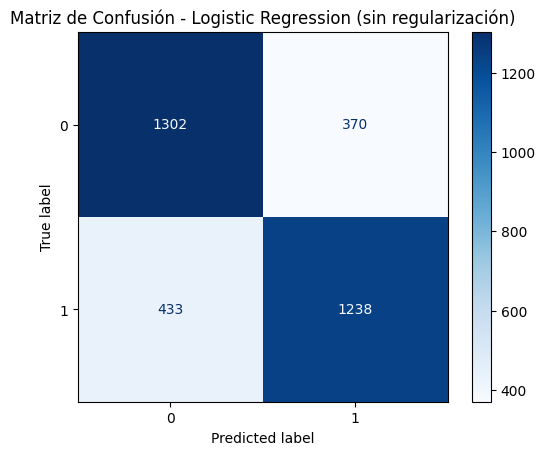

In [43]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (sin regularización)", logreg)

**Regresión Lasso (L1)**


--- Logistic Regression (Lasso - L1) ---
Accuracy: 0.7606939874364343
Precision: 0.7713395638629283
Recall: 0.7408737283064033
F1-Score: 0.7557997557997558
AUC-ROC: 0.8425741397724766

               precision    recall  f1-score   support

           0       0.75      0.78      0.77      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



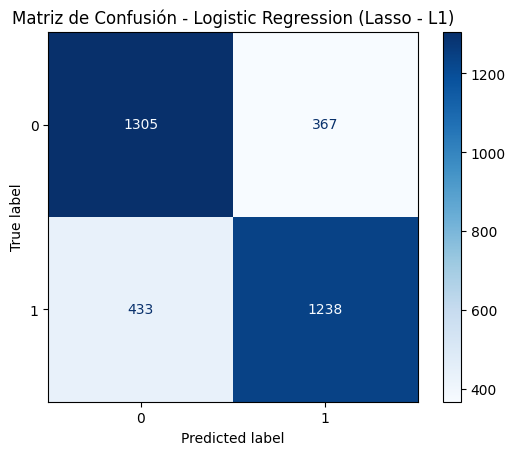

In [22]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lasso.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Lasso - L1)", lasso)

**Regresión Ridge (L2)**


--- Logistic Regression (Ridge - L2) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8423407752284252

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



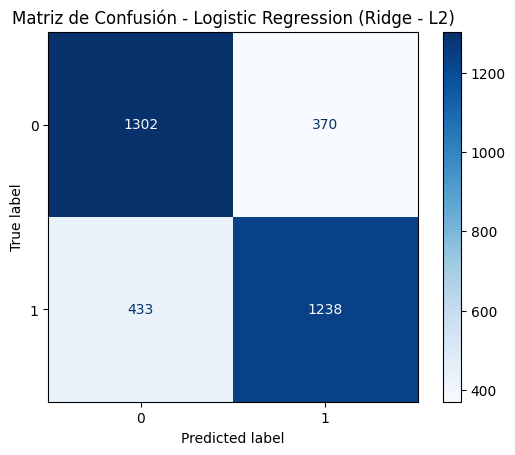

In [23]:
ridge = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
ridge.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Ridge - L2)", ridge)

**Regresión Elastic Net**


--- Logistic Regression (Elastic Net) ---
Accuracy: 0.759796589889321
Precision: 0.7699004975124378
Recall: 0.7408737283064033
F1-Score: 0.755108264714852
AUC-ROC: 0.8425000501089512

               precision    recall  f1-score   support

           0       0.75      0.78      0.76      1672
           1       0.77      0.74      0.76      1671

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



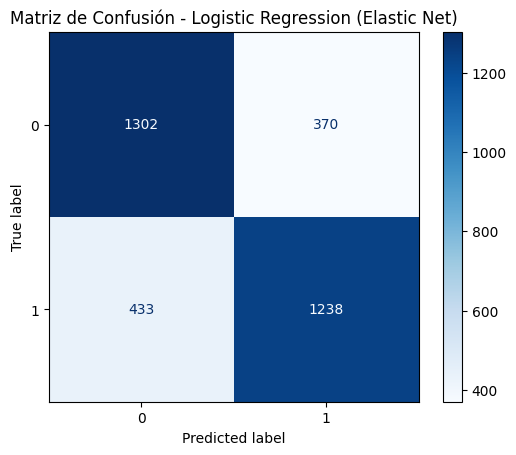

In [24]:
elastic = LogisticRegression(penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=1000, random_state=42)
elastic.fit(X_train, y_train)
evaluar_modelo("Logistic Regression (Elastic Net)", elastic)

## **Gráficos que muestran la importancia de las características y cómo impactan en las predicciones**

In [92]:
# Función para graficar la importancia de las caracteríscas por modelo
def ft_importance(model, X, top_n=None, palette='viridis', title=None):
    # Verificar que el modelo tenga el atributo
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("El modelo no tiene el atributo 'feature_importances_'.")
    # Obtener importancias
    importancias = model.feature_importances_
    features = X.columns
    # Crear DataFrame ordenado
    df_importancias = pd.DataFrame({
        'Feature': features,
        'Importancia': importancias
    }).sort_values(by='Importancia', ascending=False)

    # Seleccionar top_n si corresponde
    if top_n is not None:
        df_importancias = df_importancias.head(top_n)

    plt.figure(figsize=(10, max(4, len(df_importancias) * 0.4)))
    sns.barplot(data=df_importancias, x='Importancia', y='Feature', palette=palette)
    plt.title(title if title else 'Importancia de Características')
    plt.xlabel('Importancia')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()

    return df_importancias

/tmp/ipython-input-2216649977.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='Importancia', y='Feature', palette=palette)


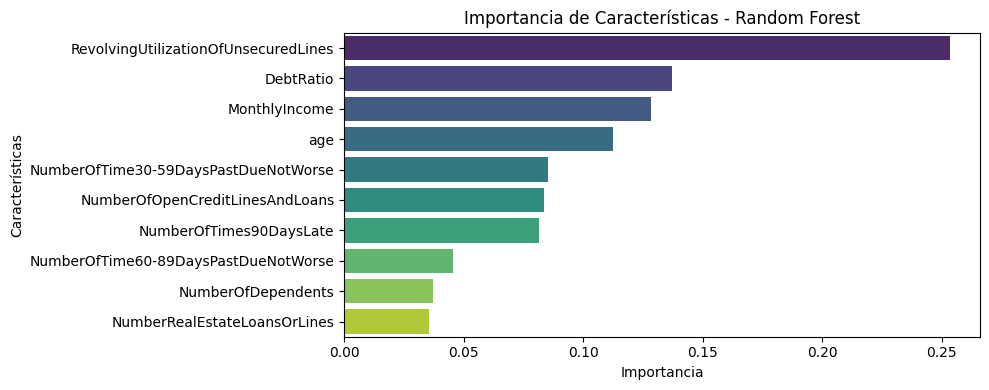

,Feature,Importancia
0,RevolvingUtilizationOfUnsecuredLines,0.253268
3,DebtRatio,0.137151
4,MonthlyIncome,0.128407
1,age,0.112569
2,NumberOfTime30-59DaysPastDueNotWorse,0.085389
5,NumberOfOpenCreditLinesAndLoans,0.083725
6,NumberOfTimes90DaysLate,0.081617
8,NumberOfTime60-89DaysPastDueNotWorse,0.045401
9,NumberOfDependents,0.036976
7,NumberRealEstateLoansOrLines,0.035496


In [72]:
ft_importance(rf, X, top_n=10, title="Importancia de Características - Random Forest")

/tmp/ipython-input-2216649977.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='Importancia', y='Feature', palette=palette)


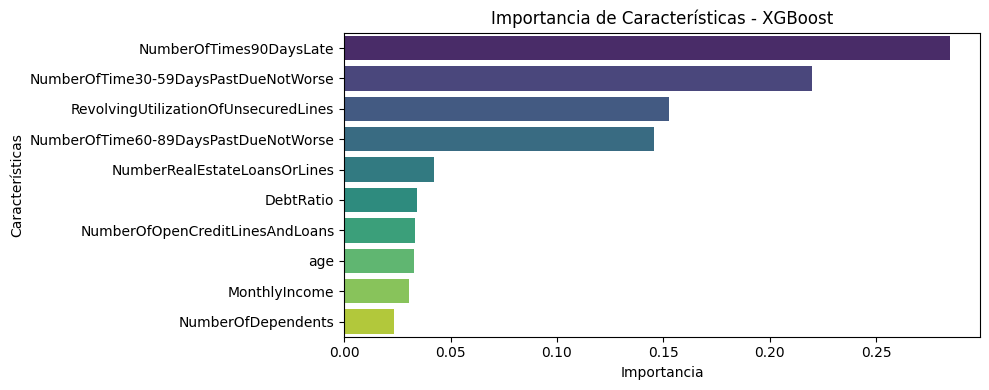

,Feature,Importancia
6,NumberOfTimes90DaysLate,0.284518
2,NumberOfTime30-59DaysPastDueNotWorse,0.219938
0,RevolvingUtilizationOfUnsecuredLines,0.152697
8,NumberOfTime60-89DaysPastDueNotWorse,0.145735
7,NumberRealEstateLoansOrLines,0.042343
3,DebtRatio,0.034412
5,NumberOfOpenCreditLinesAndLoans,0.033508
1,age,0.032597
4,MonthlyIncome,0.030661
9,NumberOfDependents,0.023591


In [73]:
ft_importance(xg, X, top_n=10, title="Importancia de Características - XGBoost")

/tmp/ipython-input-2216649977.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='Importancia', y='Feature', palette=palette)


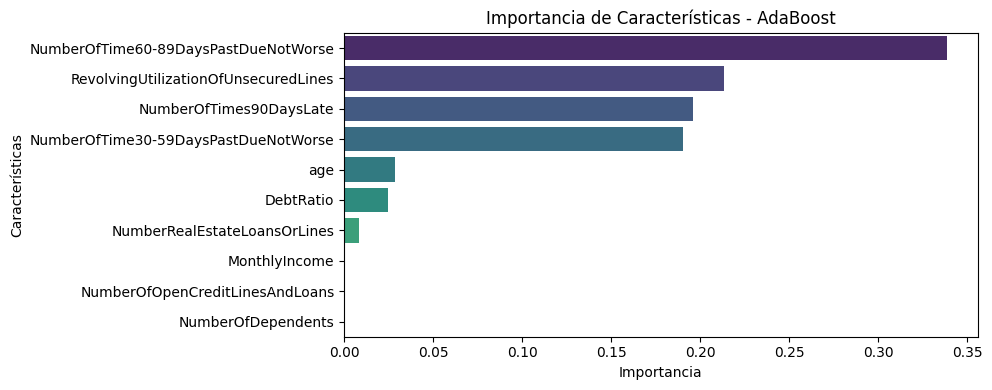

,Feature,Importancia
8,NumberOfTime60-89DaysPastDueNotWorse,0.338955
0,RevolvingUtilizationOfUnsecuredLines,0.213334
6,NumberOfTimes90DaysLate,0.195856
2,NumberOfTime30-59DaysPastDueNotWorse,0.190149
1,age,0.028528
3,DebtRatio,0.024862
7,NumberRealEstateLoansOrLines,0.008318
4,MonthlyIncome,0.000000
5,NumberOfOpenCreditLinesAndLoans,0.000000
9,NumberOfDependents,0.000000


In [74]:
ft_importance(ada, X, top_n=10, title="Importancia de Características - AdaBoost")

In [ ]:
# Función de visualización para regresiones
def plot_coef(modelo, feature_names, nombre_modelo="Regresión"):
    """
    Parámetros:
    - modelo: modelo entrenado (con atributo .coef_)
    - feature_names: lista con nombres de las características
    - nombre_modelo: título para el gráfico
    """
    # Extraer coeficientes
    coefs = modelo.coef_[0] if len(modelo.coef_.shape) > 1 else modelo.coef_
    # Crear DataFrame ordenado
    df_coef = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente': coefs
    }).sort_values(by='Coeficiente', key=abs, ascending=False)
    # Graficar
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')
    plt.title(f'Impacto de Características - {nombre_modelo}')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


- Los coeficientes del modelo indican la influencia de cada variable. Por ejemplo, en este caso, un coeficiente positivo implica que un aumento en esa variable aumenta la probabilidad de desaprobación, que el cliente posee riesgo crediticio.
- "Número de veces que el cliente tuvo pagos con 30-59 días de atraso" (sin llegar a mora grave).	Valores altos sugieren riesgo crediticio.
- "Número de veces que el cliente tuvo pagos con +90 días de atraso".	Indicador fuerte de morosidad grave.

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


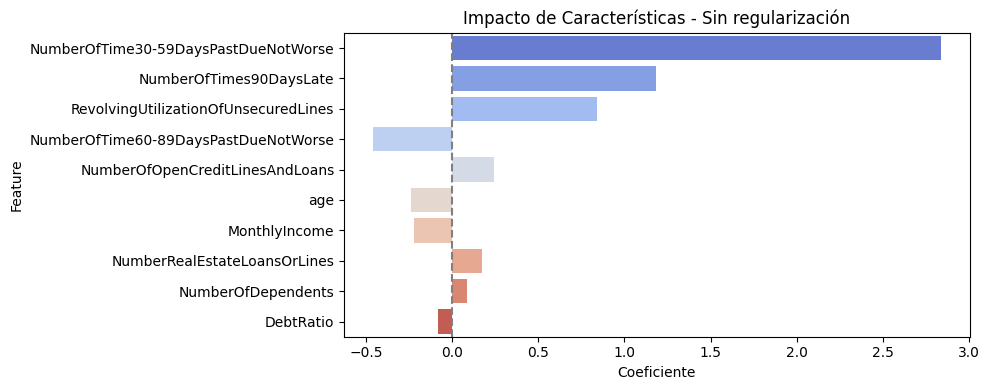

In [ ]:
plot_coef(logreg, X.columns, "Sin regularización")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


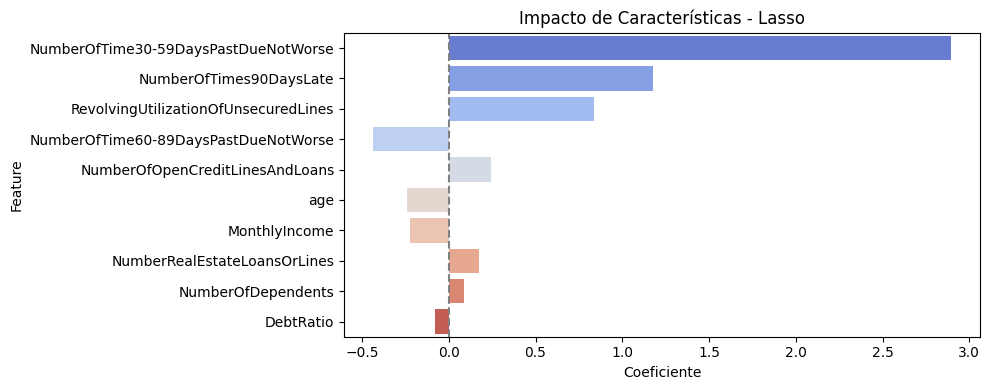

In [ ]:
plot_coef(lasso, X.columns, "Lasso")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


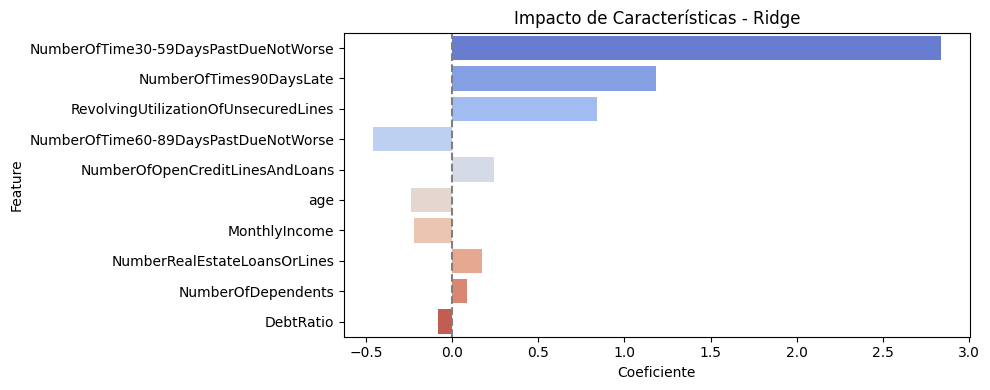

In [ ]:
plot_coef(ridge, X.columns, "Ridge")

/tmp/ipython-input-54-939371788.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coef, x='Coeficiente', y='Feature', palette='coolwarm')


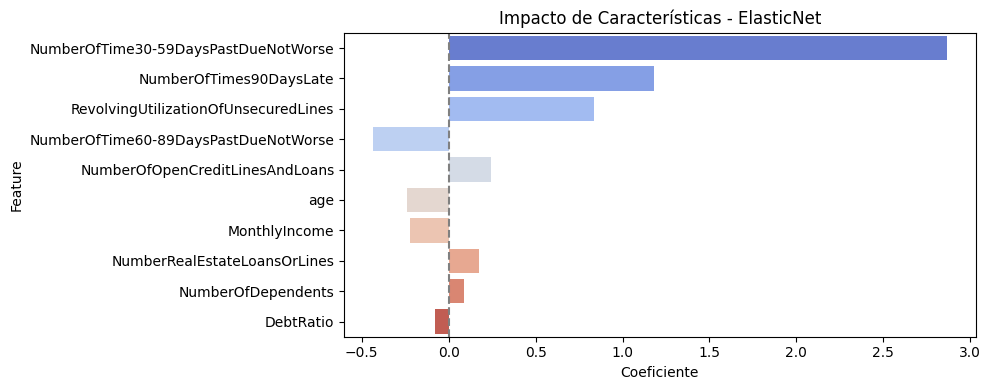

In [ ]:
plot_coef(elastic, X.columns, "ElasticNet")

## **Análisis Comparativo de Modelos de Regresión Logística**

In [76]:
# Función para recolectar métricas de los modelos
def get_metrics(model_name, model):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

In [77]:
#Obtener métricas para cada modelo
metrics_reglog = get_metrics("Regresión Logística", logreg)
metrics_lasso = get_metrics("Regresión Logística Lasso ", lasso)
metrics_ridge = get_metrics("Regresión Logística Ridge", ridge)
metrics_elastic = get_metrics("Regresión Logística Elastic Net", elastic)
#Crear DataFrame con los resultados
result_reg = pd.DataFrame([metrics_reglog, metrics_lasso,metrics_ridge,metrics_elastic])

In [78]:
result_reg

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Regresión Logística,0.759797,0.76990,0.740874,0.755108,0.842341
1,Regresión Logística Lasso,0.760694,0.77134,0.740874,0.755800,0.842574
2,Regresión Logística Ridge,0.759797,0.76990,0.740874,0.755108,0.842341
3,Regresión Logística Elastic Net,0.759797,0.76990,0.740874,0.755108,0.842500


**Comparación entre modelos**

Todos los modelos tienen métricas muy cercanas, lo que sugiere que la regularización no está teniendo un impacto significativo en este dataset. Esto puede deberse a bajo overfitting, es decir, los datos ya son linealmente separables o no tienen ruido excesivo. En este dataset la variable objetivo está dividida de manera balanceada 50/50 lo que puede ser el motivo del desempeño.

- El mejor modelo dentro de este grupo es la **Regresión Logística con Lasso (L1)**, ya que logra:

   - Mayor Accuracy (0.760694 vs. 0.759797 en los demás).

   - Mayor Precision (0.77134).

   - Mejor F1-Score (0.755800).

  - Mayor AUC-ROC (0.842574).

Aunque la diferencia es pequeña (probablemente no significativa estadísticamente), Lasso tiene la ventaja adicional de hacer selección de variables al poner a cero coeficientes irrelevantes, lo que mejora la interpretabilidad y puede beneficiar el modelo final.

## **Análisis comparativo entre algoritmos de bagging y boosting**

In [107]:
#Obtener métricas para cada modelo
metrics_rf = get_metrics("Random Forest", rf)
metrics_rf_grid = get_metrics("Random Forest Grid Search", grid_search)
metrics_rf_random = get_metrics("Random Forest Random Search", best_random)
metrics_rf_opt = get_metrics("Random Forest Opt Bayesiana", opt)
metrics_xg = get_metrics("XGBoost", xg)
metrics_ada = get_metrics("AdaBoost", ada)

#Crear DataFrame con los resultados
result_ensamb = pd.DataFrame([metrics_rf, metrics_rf_grid, metrics_rf_random, metrics_rf_opt, metrics_xg, metrics_ada])

In [110]:
result_ensamb

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.775950,0.774405,0.778576,0.776485,0.852125
1,Random Forest Grid Search,0.781334,0.784160,0.776182,0.780150,0.861878
2,Random Forest Random Search,0.781633,0.783947,0.777379,0.780649,0.861530
3,Random Forest Opt Bayesiana,0.779240,0.781193,0.775583,0.778378,0.861038
4,XGBoost,0.780736,0.792394,0.760622,0.776183,0.860032
5,AdaBoost,0.769070,0.784314,0.742071,0.762608,0.849645


**Comparación entre modelos:**


- En Accuracy, el mejor es **Random Forest Random Search** (0.781633), apenas por encima de Grid Search (0.781334).

- En F1-Score, también gana Random Forest Random Search (0.780649).

- En AUC-ROC, gana Random Forest Grid Search (0.861878), seguido muy de cerca por Random Search (0.861530).

- En Precision, XGBoost tiene el valor más alto (0.792394), pero sacrifica Recall y F1-Score.

- Mejor balance general: Random Forest Random Search

    - Mantiene el mayor Accuracy y F1-Score.

    - Tiene un AUC-ROC casi idéntico al mejor (diferencia de 0.000348).

    - Rendimiento muy parejo en todas las métricas, sin sacrificar Recall.

## **Resumen de Comparación de Modelos de Clasificación**

**Análisis comparativo de Random Forest optimizado con Random Search y Regresión Logística Lasso (mejor entre las regresiones)**

In [111]:
#Crear DataFrame con los resultados
resultF = pd.DataFrame([metrics_rf_random, metrics_lasso])
resultF

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest Random Search,0.781633,0.783947,0.777379,0.780649,0.861530
1,Regresión Logística Lasso,0.760694,0.771340,0.740874,0.755800,0.842574


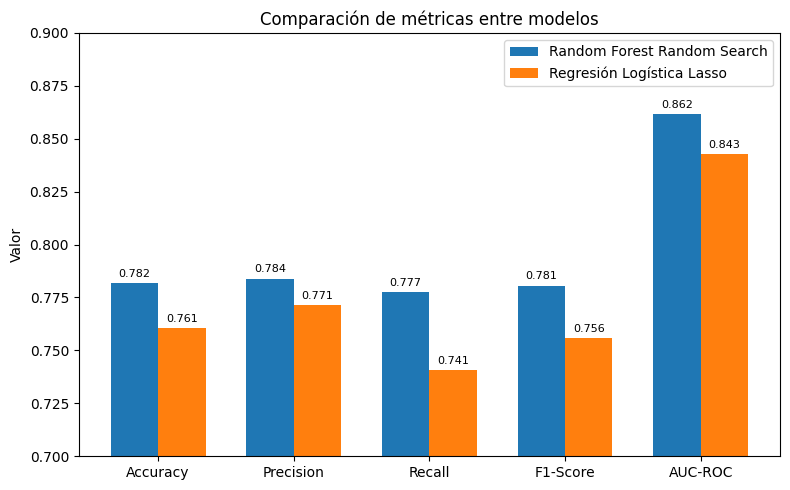

In [112]:
# Gráfica de la comparación de modelos
metrics = resultF.columns[1:]
x = np.arange(len(metrics))  # posiciones en el eje X
width = 0.35  # ancho de cada barra

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, resultF.loc[0, metrics], width,
               label=resultF.loc[0, 'Modelo'], color='#1f77b4')
bars2 = ax.bar(x + width/2, resultF.loc[1, metrics], width,
               label=resultF.loc[1, 'Modelo'], color='#ff7f0e')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre modelos')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.7, 0.9)  # ajusta rango visual
ax.legend()

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Conclusión**

En la fase de evaluación de modelos, se analizaron dos enfoques principales para la predicción de riesgo crediticio: modelos de regresión logística (con regularización Lasso, Ridge y Elastic Net) y modelos de ensamble (Random Forest, XGBoost y AdaBoost), aplicando distintas estrategias de optimización de hiperparámetros.

Dentro del grupo de modelos de regresión, el mejor desempeño lo obtuvo la Regresión Logística con regularización Lasso (L1), alcanzando un Accuracy de 0.7607, un F1-Score de 0.7558 y un AUC-ROC de 0.8426. Este modelo presentó un buen equilibrio entre precisión y exhaustividad, además de la ventaja adicional de realizar selección de variables, mejorando la interpretabilidad.

En el grupo de modelos de ensamble, el rendimiento más alto se logró con Random Forest optimizado mediante búsqueda aleatoria de hiperparámetros (Random Search). Este modelo obtuvo un Accuracy de 0.7816, un F1-Score de 0.7806 y un AUC-ROC de 0.8615, superando a los demás en casi todas las métricas clave. Su desempeño muestra una mejora significativa respecto a la regresión logística, particularmente en la capacidad de discriminar entre clientes de alto y bajo riesgo.

El Random Forest con búsqueda aleatoria de hiperparámetros es claramente superior:

- Accuracy +2.1 puntos respecto a Lasso.

- F1-Score notablemente mayor (+0.025).

- AUC-ROC más alto (+0.019), lo que significa mejor discriminación entre clases.

- Buen equilibrio entre Precision y Recall, lo que es clave en un problema de riesgo crediticio.

En un escenario real, esto significa que Random Forest Random Search no solo clasifica más casos correctamente, sino que también identifica mejor a los clientes de alto riesgo sin perder demasiados casos positivos.

La regresión logística (con o sin regularización) permite ver coeficientes positivos o negativos y cómo cada variable afecta la probabilidad de aprobación, pero quedan descartadas por su menor rendimiento en este caso.